In [198]:
import numpy as onp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import corner

In [188]:
import jax 
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax.nn import relu, elu
import optax 

from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [625]:
class pcann():
    def __init__(self, 
                 layer_sizes=[3, 5, 5, 2], 
                 key=random.PRNGKey(1)):
        self.params = self.initialize_mlp(layer_sizes, key)
        self.batch_forward = vmap(self.forward_pass, in_axes=(None, 0))
        self.initialize_opt()
        
    def init_pca(self, n_components=4):
        self.pca = PCA(n_components=n_components)
        
    def fit_pca(self, ys):
        self.pca.fit(ys)
        print(f'PCA explained variance : {self.pca.explained_variance_ratio_}')
        print(f'PCA total explained variance : {sum(self.pca.explained_variance_ratio_)}')
        self.pca_comp = self.pca.components_
        self.pca_mean = self.pca.mean_
    
    def train(self, xs, ys, epochs=5000, verbose=True, plot=True):
        for i in range(epochs):
            grads = jax.grad(self.loss)(self.params, xs, ys)
            updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
            self.params = optax.apply_updates(self.params, updates)
            if i%(epochs / 10) == 0 and verbose:
                print(f'Epoch {i}: Loss is {self.loss(self.params, xs, ys)}')
        
    def initialize_opt(self, lr=2e-2):
        self.optimizer = optax.adam(lr)
        self.opt_state = self.optimizer.init(self.params)
        
    def pred(self, params, x):
        return self.batch_forward(params, x)
        
    def loss(self, params, x, y):
        preds = self.pred(params, x)
        loss = np.mean(optax.l2_loss(preds, y))
        return loss
        
    def forward_pass(self, params, x):
        """ Compute the forward pass for each example individually """
        activations = x

        # Loop over the hidden layers
        for w, b in params[:-1]:
            outputs = np.dot(w, activations) + b  # apply affine transformation
            activations = relu(outputs)  #  apply nonlinear activation

        # Perform final mlp output
        w, b = params[-1]
        outputs = (np.dot(w, activations) + b)
        
        # Add pca inverse transform to the output
        final_outputs = np.dot(outputs, self.pca_comp) + self.pca_mean
        return final_outputs
        
    def initialize_mlp(self, sizes, key):
        """ Initialize the weights of all layers of a linear layer network """
        keys = random.split(key, len(sizes))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, key, scale=1e-2):
            w_key, b_key = random.split(key)
            return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
        return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [626]:
key = jax.random.PRNGKey(42)

Ndim = 32
cov = onp.empty([Ndim, Ndim])
for i in range(Ndim):
    for j in range(Ndim):
        if i == j:
            cov[i, j] = 1
        else:
            cov[i, j] = cov[j, i] = onp.random.rand(1) * 0.1 + 0.5
mean = onp.zeros(Ndim)

# Generate some data.
xy = onp.random.multivariate_normal(mean=mean, cov=cov, size=(1000, ))

xy[:, -5] = 0.99 * xy[:, -6] + xy[:, -5] * 0.01
xy[:, -3] = 0.99 * xy[:, -4] + xy[:, -3] * 0.01
xy[:, -1] = 0.99 * xy[:, -2] + xy[:, -1] * 0.01


xs = xy[:, :int(Ndim/2)]
ys = xy[:, int(Ndim/2):]


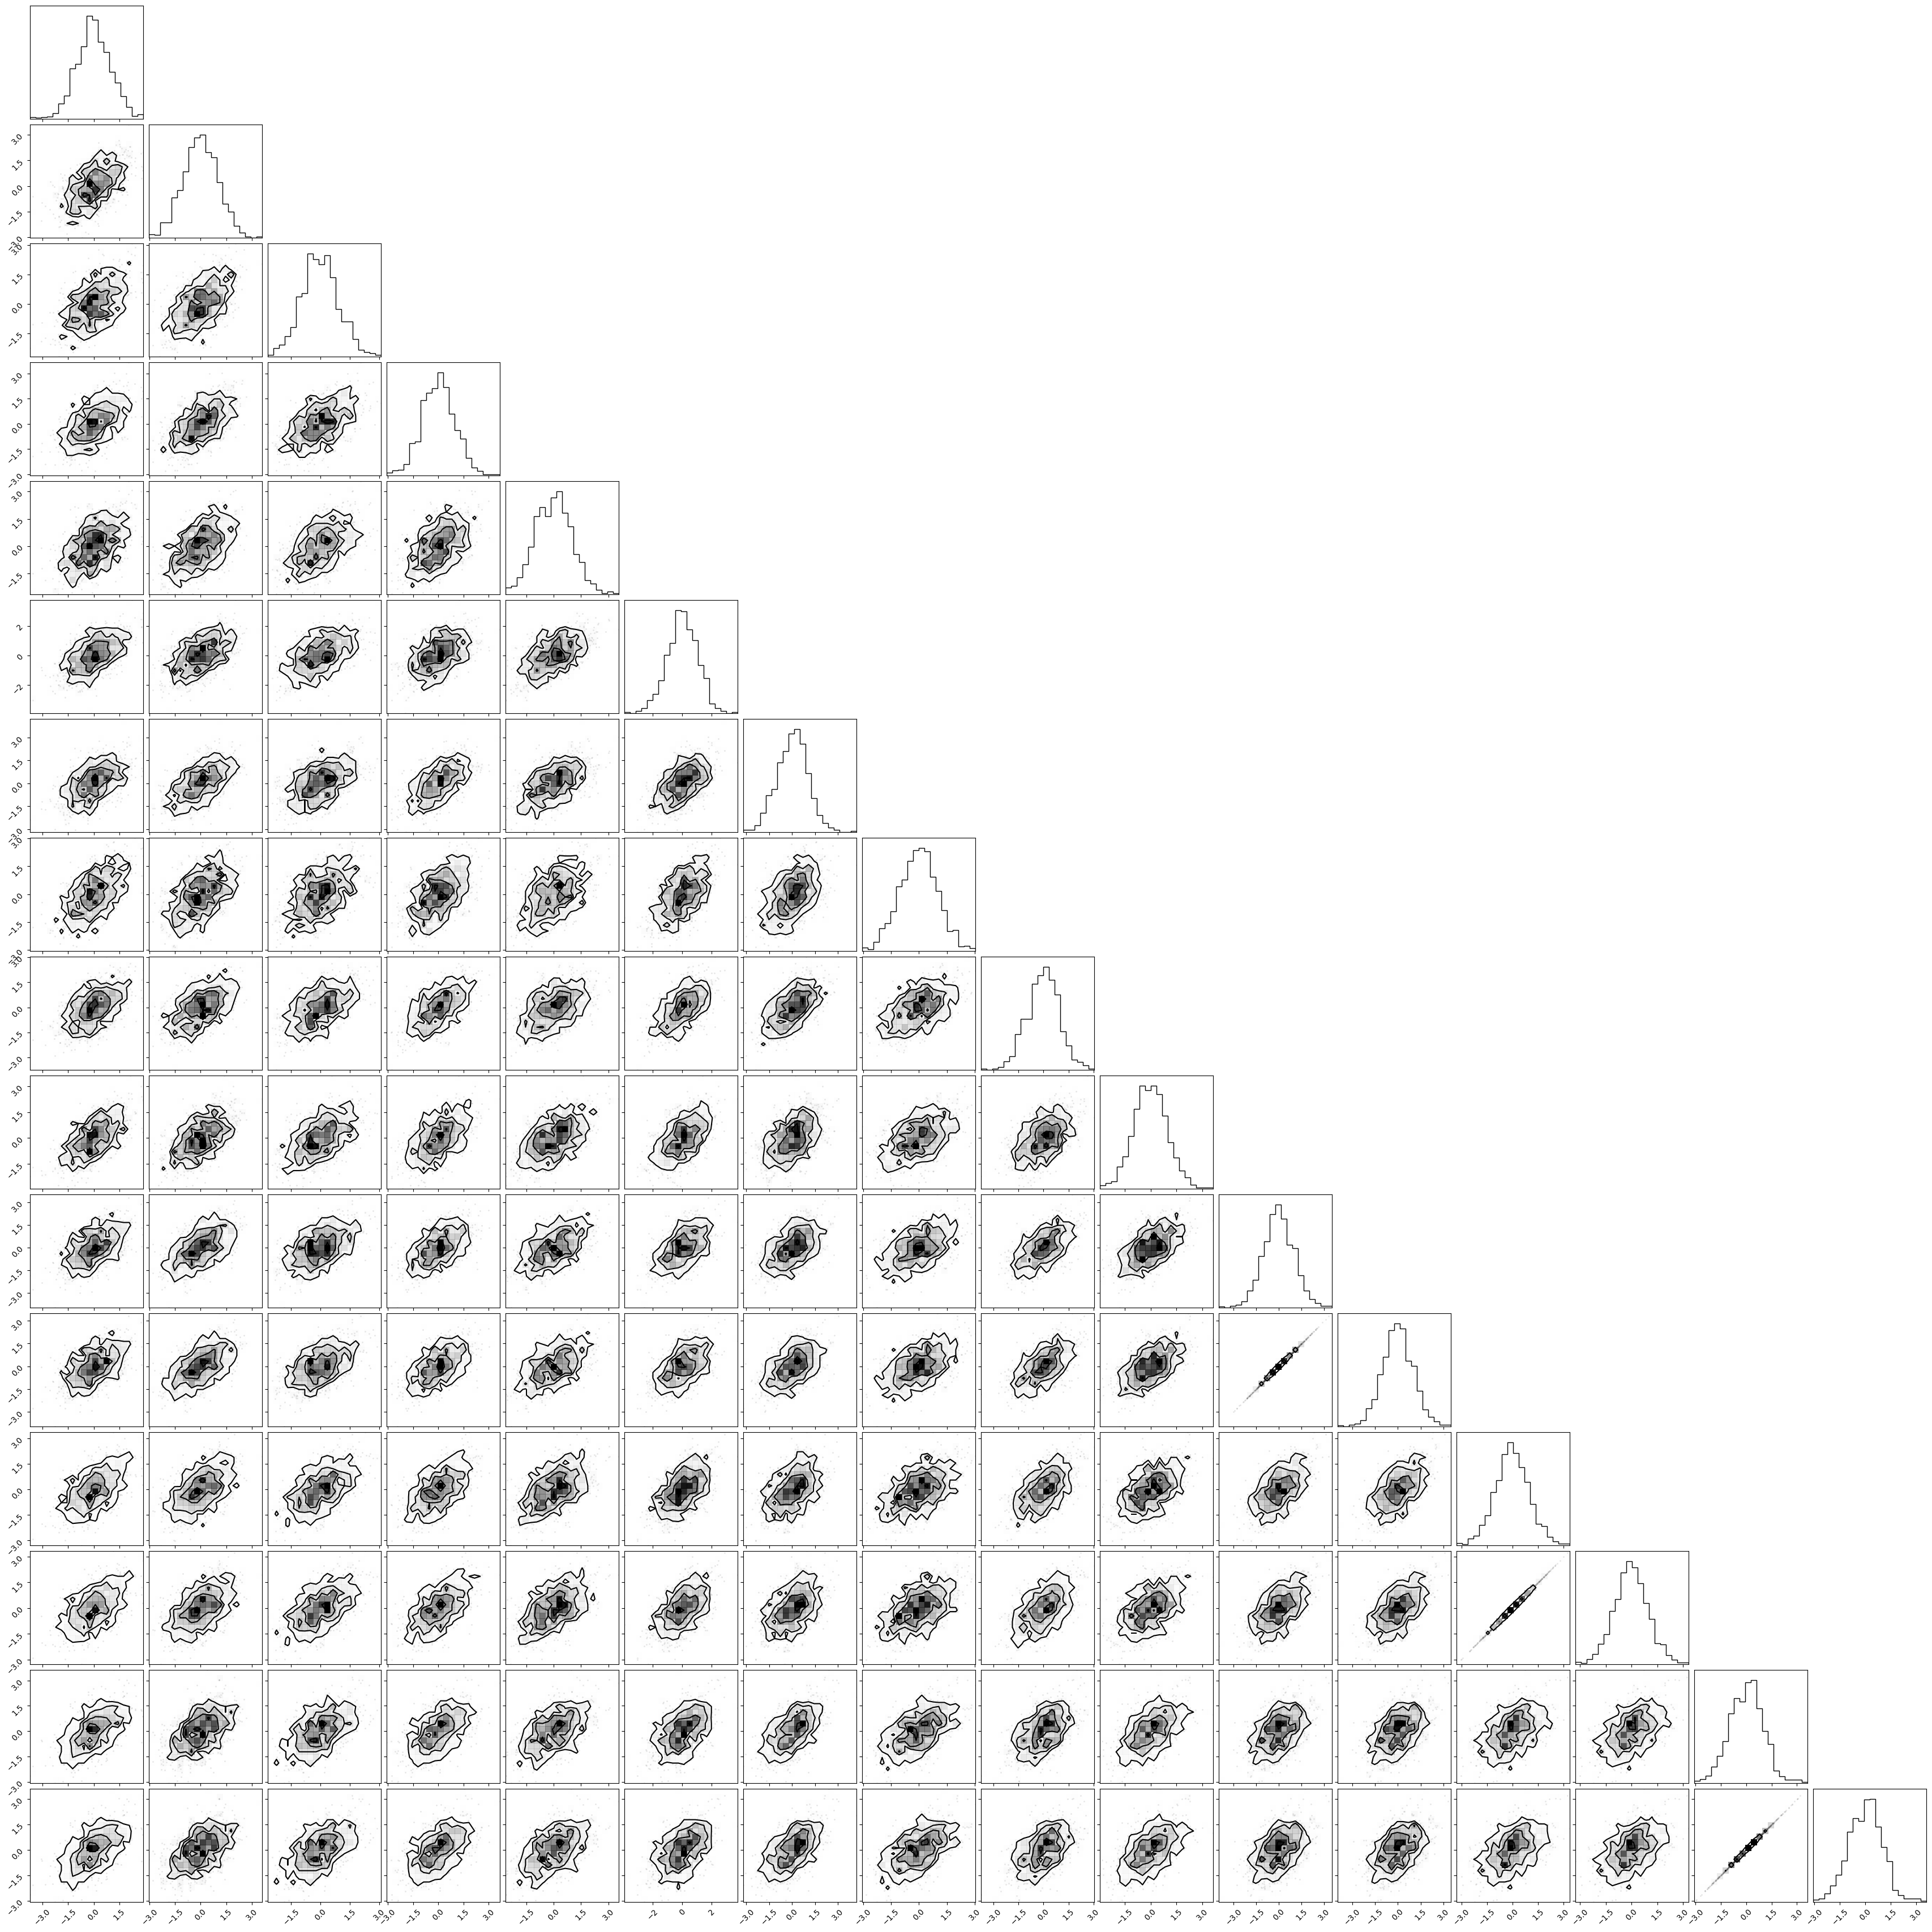

In [627]:
corner.corner(ys);

In [648]:
pca_n_comps = 8
nn = pcann(layer_sizes = [int(Ndim/2), 32, 32, 32, pca_n_comps])
nn.init_pca(n_components=pca_n_comps)
nn.fit_pca(ys)
nn.train(np.asarray(xs), np.asarray(ys))

PCA explained variance : [0.57460449 0.07148293 0.0552452  0.04214699 0.03747284 0.03621987
 0.03479245 0.02985439]
PCA total explained variance : 0.8818191497752003
Epoch 0: Loss is 0.4859214425086975
Epoch 500: Loss is 0.18892228603363037
Epoch 1000: Loss is 0.1703997254371643
Epoch 1500: Loss is 0.16448985040187836
Epoch 2000: Loss is 0.1600588709115982
Epoch 2500: Loss is 0.15950235724449158
Epoch 3000: Loss is 0.15832020342350006
Epoch 3500: Loss is 0.15759724378585815
Epoch 4000: Loss is 0.15695451200008392
Epoch 4500: Loss is 0.1553291529417038


In [649]:
preds = nn.pred(nn.params, xs)

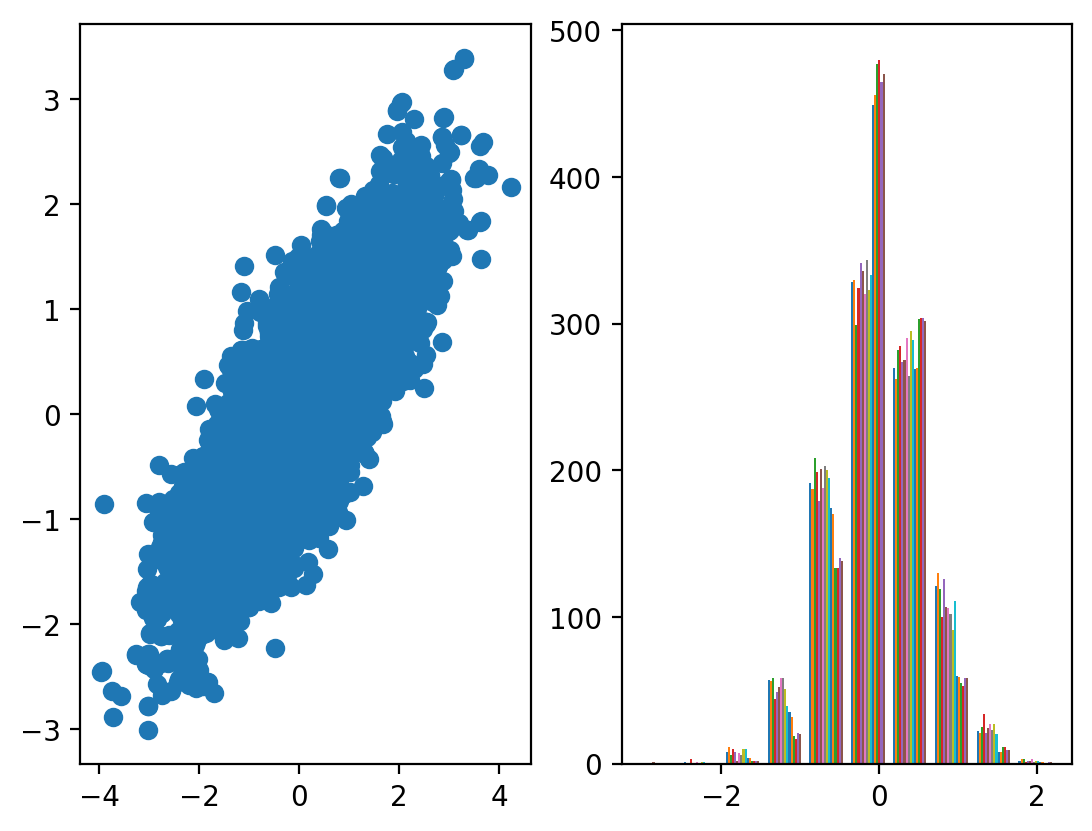

In [650]:
fig, ax = plt.subplots(1, 2, dpi=200)

n = 1000

ax[0].scatter(ys[:n, ...], preds[:n, ...])

ax[1].hist(onp.array(ys - preds));

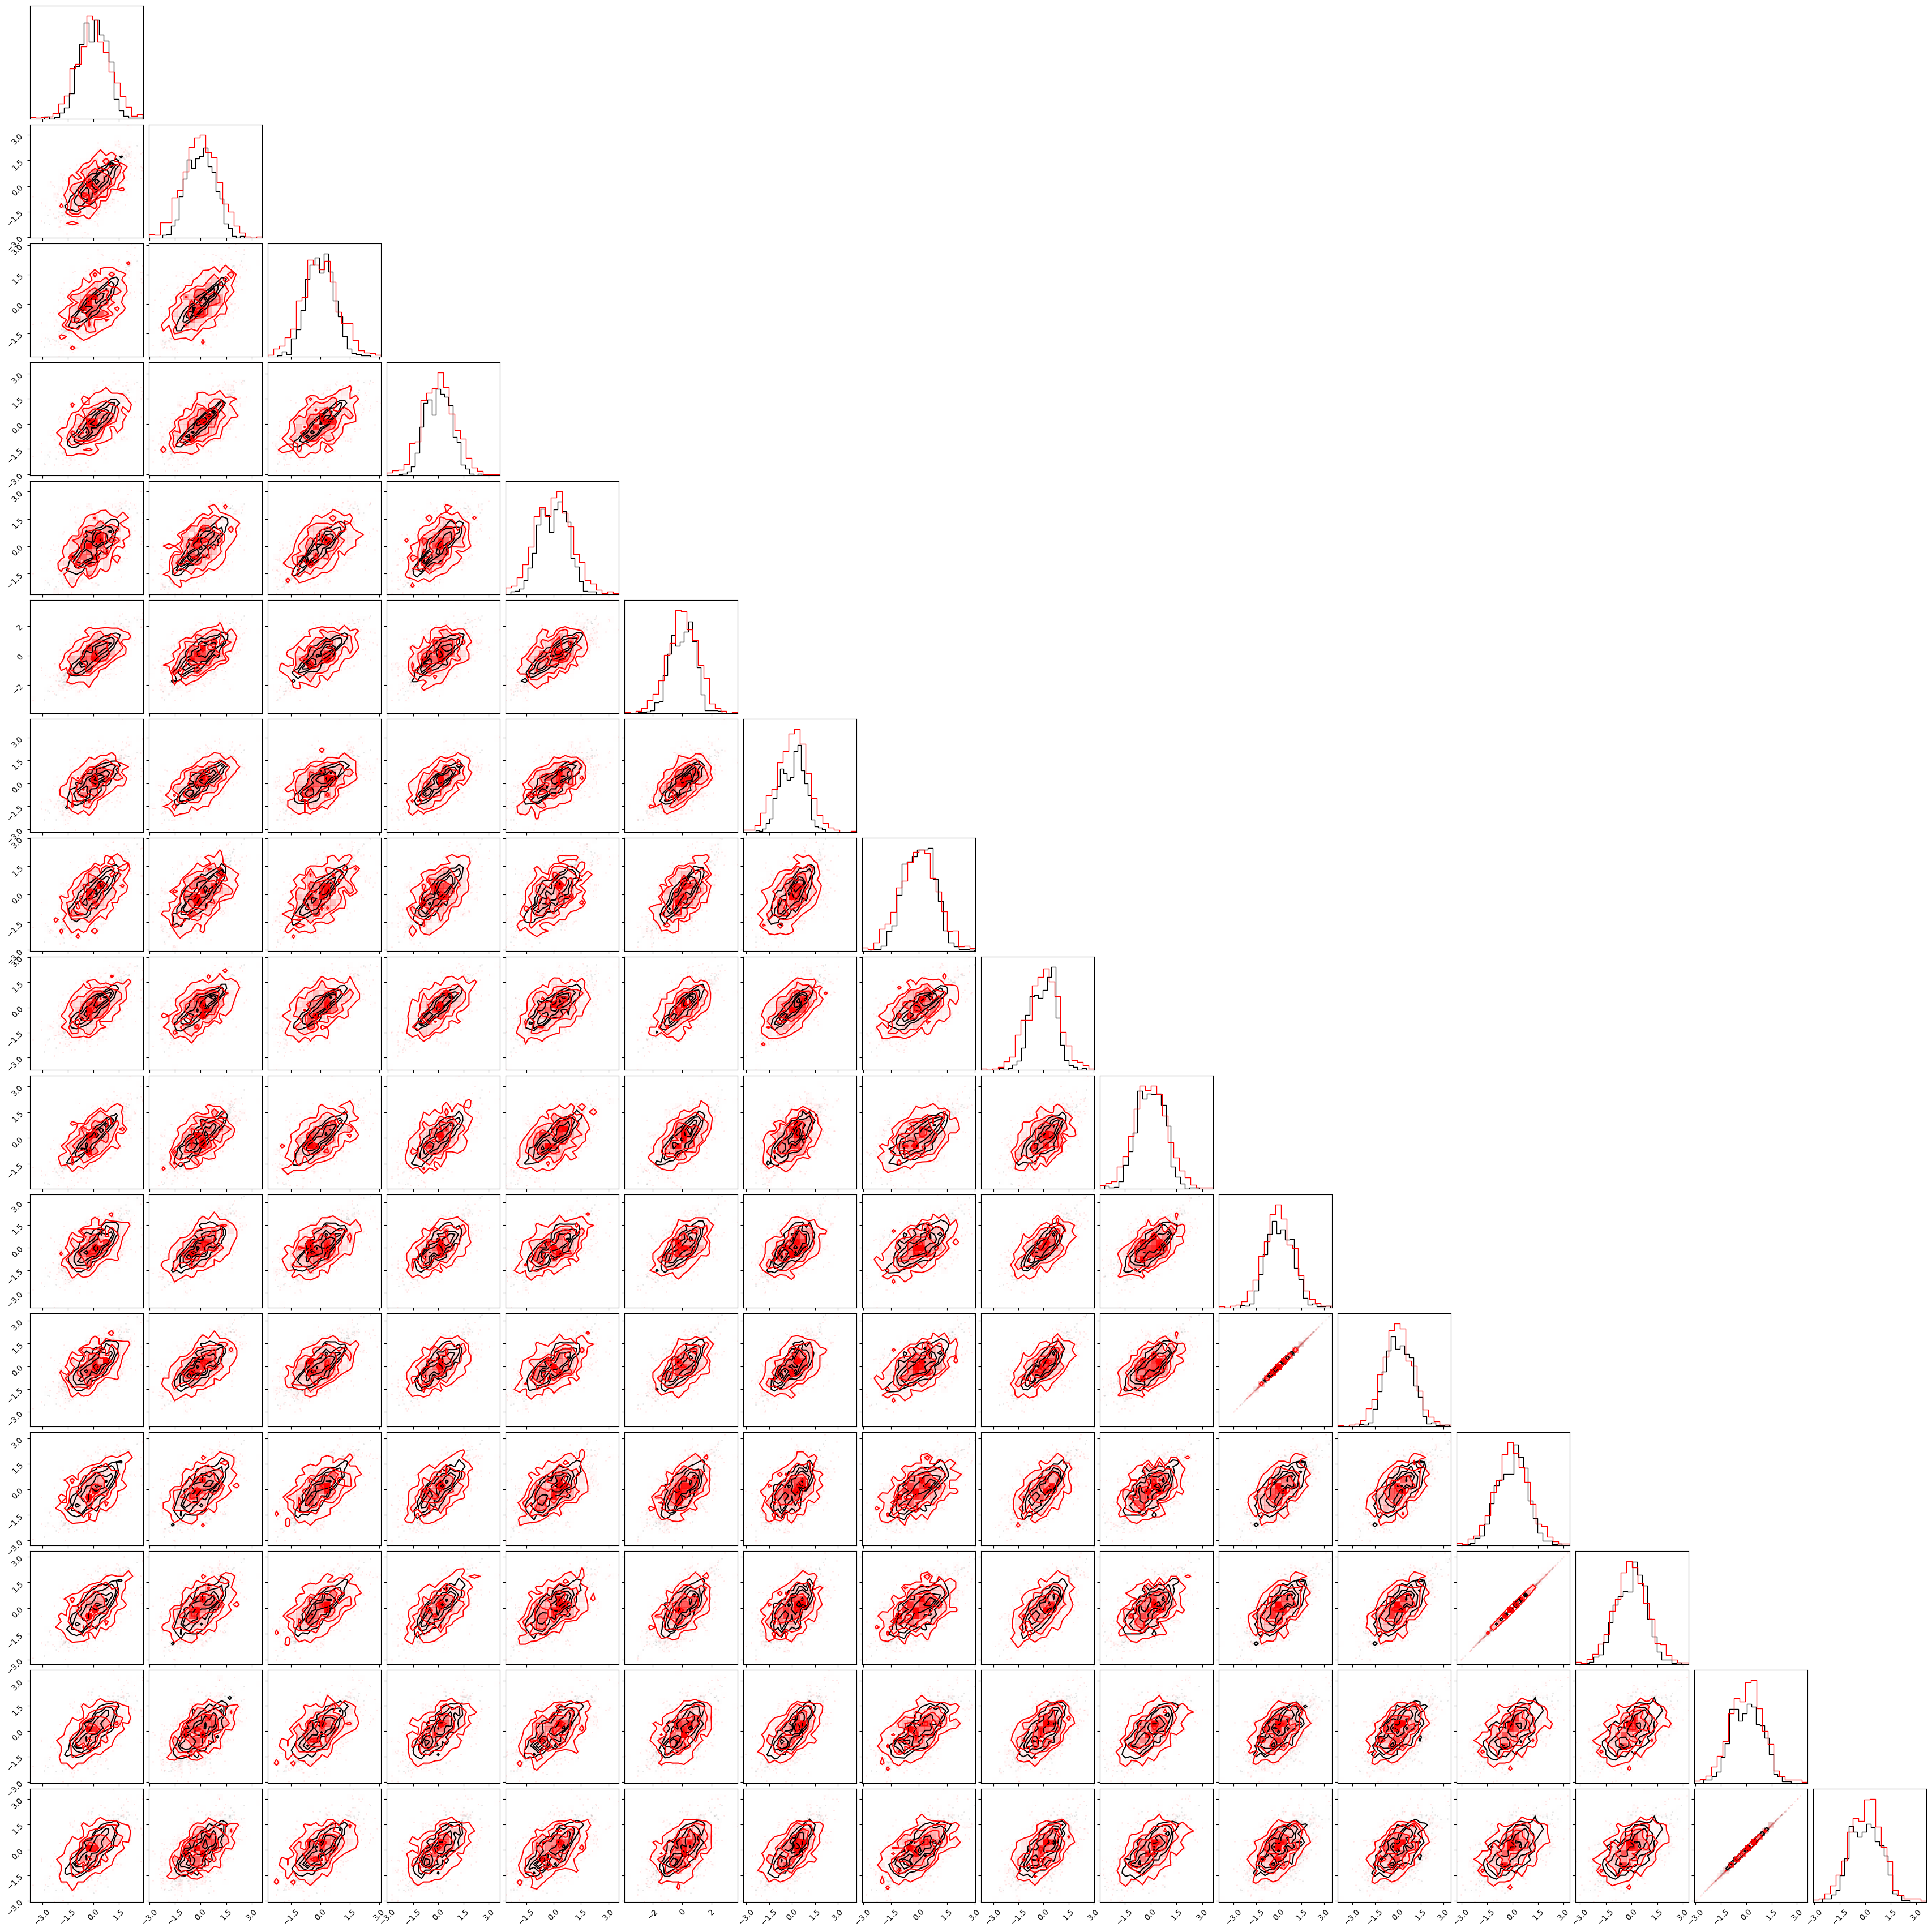

In [651]:
fig = corner.corner(onp.array(preds), color='k');
corner.corner(onp.array(ys), fig=fig, color='r');